# **Text Segmentation Experiments**

В данном ноутбуке я покажу эксперименты с различными моделями, которые я подобрал для решения задачи сегментации текстов. 

***Суть задачи:*** разбиение текста на части, состоящие из близких по смыслу и теме предложений. \
***Данные:*** набор текстов историй с сайта tjournal \
***Метки предложений:*** 0 - предложения абзаца, 1 - первое предложение абзаца, 2 - первое предложение секции.

In [ ]:
! git clone https://github.com/grgera/Text-Segmentation.git

In [ ]:
% cd Text-Segmentation/

## 1). Загрузка данных

In [ ]:
!wget -P /content/Text-Segmentation https://www.dropbox.com/s/rexdmrlcj2nlbjs/data.jsonl

In [4]:
from utils import *

data_list = read_json('data.jsonl')
dataframe = dt_to_pd(data_list)

In [5]:
print("Данные содержат {} предложение".format(dataframe.shape[0]))

Данные содержат 116601 предложение


Выведем распределение по классам в документах.

In [6]:
dataframe.groupby([1]).count()

,0
1,
0,78737
1,34011
2,3853


По смыслу задачи, ну и это можно увидеть выше, данные сильно несбалансированы, особенно это касается разметки для разбиения на секции.

Посмотрим на распределение количества слов в предложениях.

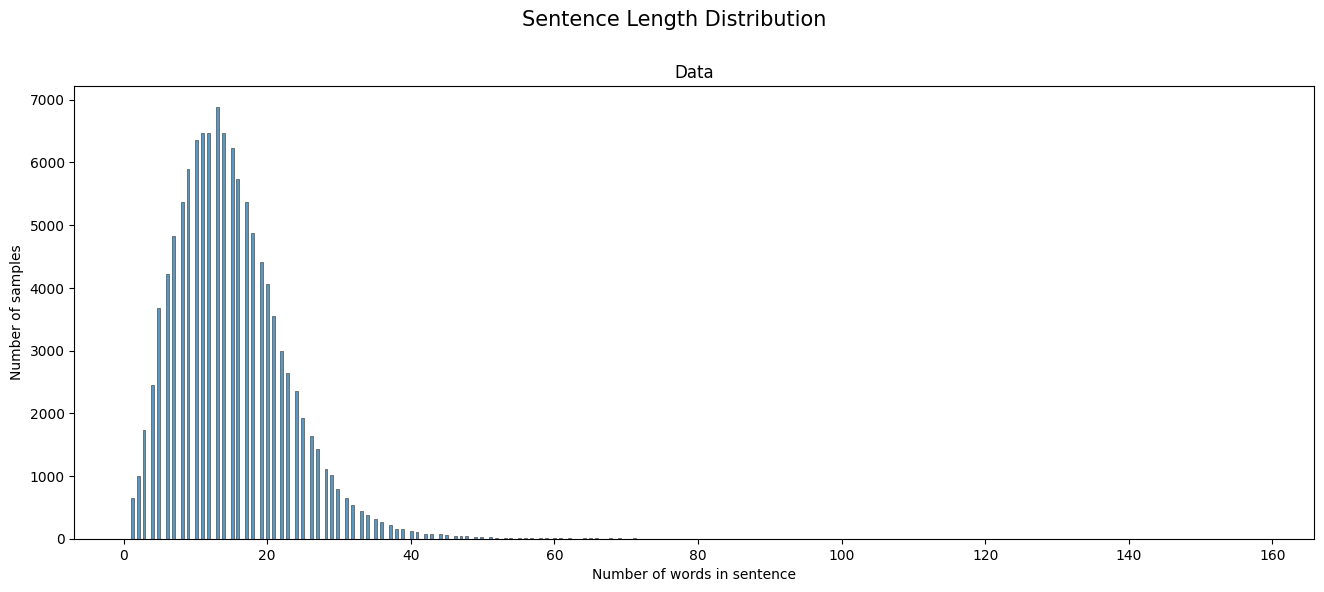

In [7]:
words_in_sentences(dataframe)

In [ ]:
! pip install -r requirements.txt

In [ ]:
! wandb login

In [10]:
! mkdir logging

## 2). Подходы для решения задачи

Я выбрал подходы в которых задача разбивается на два этапа: 

*   сбор и анализ контекстов - получение эмбеддингов предложений
*   классификация предложений

Для решения первого пункта решено было использовать BERT-like модель. Необходимо "скормить" предложения на вход энкодера и в конце получить эмбеддинги каждого из них.



Второй пункт я решаю либо при помощи BERT-like модели, либо BiLSTM.

Также я решил попробовать обучить каждую модель на два метода классификации. 


---


В первом случае, сегментировать тексты будут две идентичные модели бинарной классификации 

*   У первой: 0 - обычное предложение, 1 - первое предложение абзаца
*   У второй: 0 - обычное предложение, 1 - первое предложение секции

Предложения исходной разметки, помечающие секции, у первой модели станут 0, у второй идентично с абзацами.

---


Во втором случае, сегментировать тексты будет модель многоклассовой классифкации, исходная разметка не будет затронута.


---






### 2.1) SBERT + BERT-Base

Первым и самым очевидным подходом было бы использование либо [CLS] токена, либо усреднение эмбеддингов токенов предложения с последнего слоя модели. Однако, в статье [SentenceBERT](https://arxiv.org/pdf/1908.10084.pdf) авторы показали, что этот путь извлечения векторов предложений имеет низкий скор на различных датасетах. Там же был представлен SBERT энкодер, именно который и будет взят для первого подхода.

В классе `SBERT_Embedding` реализуется препроцессинг данных, разбиение на три выборки 76.5%/8.5%/15% без перемешивания, перевод предложений при помощи `SentenceTransformers` в вектора и обертка в TensorDataset. Именно этот датасет далее идет на вход BERT-like модели (в данных опытах была выбрана модель 'bert-base-uncased'). Для более удобного проведения экспериментов и контроля их качества модель обернута в PyTorch Lightning и привязан логгер Weights&Baises. 

Итак, модель [SBERT](https://github.com/grgera/Text-Segmentation/blob/main/sentence_embeddings/sbert.py) + [BERT-base](https://github.com/grgera/Text-Segmentation/blob/main/models/bert.py) классифкация на 3 класса.

In [ ]:
! python train.py --config config.yaml --emb_type 'SBERT'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/SBERT-BERT-on-3-classes---VmlldzoyMjk0MTA2?accessToken=3csg4qk341ndqnhes93p5m5dbucsgcu6j12gfz42ht6m8v6zrr1sfkofaks6vfj3)

In [ ]:
! python test.py --config config.yaml --emb_type 'SBERT'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_123032-1hdn9y63
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vague-glade-4
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/1hdn9y63
Batches: 100% 1394/1394 [00:57<00:00, 24.08it/s]
Batches: 100% 155/155 [00:06<00:00, 23.36it/s]
Batches: 100% 274/274 [00:11<00:00, 24.50it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:03<00:00, 76.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Теперь посмотрим на две модели той же архитектуры, но с бинарной классификацией. Сначала это будет модель для абзацев, затем для секций. Стоит заметить, что пытаясь бороться с сильным дисбалансом классов, я использую веса лейблов в `CrossEntropyLoss`. Для оценки выбраны метрики `f1_score` и `accuracy_score`.

In [ ]:
! python train.py --config config.yaml --emb_type 'SBERT' --binary_mode 'paragraph'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/SBERT-BERT-on-2-classes-paragraph---VmlldzoyMjk0MTc5?accessToken=lwi7rdofzm0qalpg8t1ju1e3evqel7vej49nm5bkib59uy89v4m1dzudaijioddl)

In [ ]:
! python test.py --config config.yaml --emb_type 'SBERT' --binary_mode 'paragraph'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_125532-jrbo8p3h
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cosmic-flower-6
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/jrbo8p3h
Batches: 100% 1394/1394 [00:59<00:00, 23.42it/s]
Batches: 100% 155/155 [00:06<00:00, 24.27it/s]
Batches: 100% 274/274 [00:10<00:00, 25.07it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:03<00:00, 76.22it/s]
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
! python train.py --config config.yaml --emb_type 'SBERT' --binary_mode 'section'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/SBERT-BERT-on-2-classes-section---VmlldzoyMjk0MjM0?accessToken=0lyv8q7fkvcz7dnz3ayrc6ajaa2tpph1ps2otpgj1xxmqd1lhcsm2kvwau4kgfn6)

In [ ]:
! python test.py --config config.yaml --emb_type 'SBERT' --binary_mode 'section'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_132040-m0cu41b6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-sun-8
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/m0cu41b6
Batches: 100% 1394/1394 [00:59<00:00, 23.34it/s]
Batches: 100% 155/155 [00:06<00:00, 23.98it/s]
Batches: 100% 274/274 [00:10<00:00, 24.91it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:04<00:00, 67.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  

### 2.2) LaBSE + BERT-Base

Вторым подходом я решил рассмотреть [LaBSE](https://arxiv.org/pdf/2007.01852.pdf) (language-agnostic BERT sentence embedding). Мультиязычный энкодер для предложений от Google, который показывал достаточно хорошее качество. В качестве классификатора снова выбрана BERT-like модель ('bert-base-uncased').

В классе `LABSE_Embedding` реализуется препроцессинг данных, разбиение на три выборки 76.5%/8.5%/15% без перемешивания, перевод предложений при помощи `LaBSE-en-ru` в вектора и обертка в TensorDataset. Также при токенизации предложений они фиксируются размером 128, меньшие дополняются паддингом, большие обрезаются. Как было показано в начале ноутбука в среднем длины предложений основной массы исходных данных варьируются от 10-20 слов.

Модель [LaBSE](https://github.com/grgera/Text-Segmentation/blob/main/sentence_embeddings/labse.py) + [BERT-base](https://github.com/grgera/Text-Segmentation/blob/main/models/bert.py) классифкация на 3 класса.

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BERT-on-3-classes---VmlldzoyMjk0MzYx?accessToken=1hgpb3895ytl7ddyfzmw82x54gxtkrw032k2gc8gi38gz317owro7w0t32o2szmk)

In [ ]:
! python test.py --config config.yaml --emb_type 'LABSE'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_141836-261z615a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run drawn-night-13
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/261z615a
100% 1394/1394 [11:29<00:00,  2.02it/s]
100% 155/155 [01:16<00:00,  2.03it/s]
100% 274/274 [02:14<00:00,  2.03it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:03<00:00, 75.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric       

Теперь посмотрим на две модели той же архитектуры, но с бинарной классификацией. Сначала это будет модель для абзацев, затем для секций. Здесь тоже используются веса классов для функции потерь.

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE' --binary_mode 'paragraph'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BERT-on-2-classes-paragraph---VmlldzoyMjk0OTMz?accessToken=016403q7x70bw474ezrj94p4cxlee2cd20zhi9nib3bedj4pfpvc5ftsmdp6ht7q)

In [ ]:
! python test.py --config config.yaml --emb_type 'LABSE' --binary_mode 'paragraph'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_150935-2i63xfy7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peachy-river-15
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/2i63xfy7
100% 1394/1394 [11:26<00:00,  2.03it/s]
100% 155/155 [01:16<00:00,  2.03it/s]
100% 274/274 [02:14<00:00,  2.04it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:03<00:00, 74.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric      

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE' --binary_mode 'section'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BERT-on-2-classes-section---VmlldzoyMjk0OTQz?accessToken=yuxr5f86myfb6hv82uxd4htt1pnk3y5aqt8nek26k7maga7a6af9n1l16cep78te)

In [ ]:
! python test.py --config config.yaml --emb_type 'LABSE' --binary_mode 'section'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_155954-1orlf1h1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficient-pond-17
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/1orlf1h1
100% 1394/1394 [11:31<00:00,  2.02it/s]
100% 155/155 [01:16<00:00,  2.03it/s]
100% 274/274 [02:15<00:00,  2.02it/s]
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:03<00:00, 79.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric    

### 2.3) LaBSE + Bi-LSTM

Третий подход - оставляем для получения эмбеддингов предложений LaBSE энкодер, а вот модель с классификатором теперь будет BiLSTM. BiLSTM проявляет себя лучше на текстах, где длина последовательности много больше вектора скрытого представления.

Итак, [LaBSE](https://github.com/grgera/Text-Segmentation/blob/main/sentence_embeddings/labse.py) + [BiLSTM](https://github.com/grgera/Text-Segmentation/blob/main/models/bilstm.py) классификация на 3 класса.

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE' --sec_model 'LSTM'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BiLSTM-on-3-classes---VmlldzoyMjk1Mjg0?accessToken=kx203xml7ueluui8qcfuxzb03gbla3updv94f0fa08r5j0nuyh0mv8pwv6y2z6ch)

In [ ]:
! python test.py --config config.yaml --emb_type 'LABSE' --sec_model 'LSTM'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_202828-hbs7vpn7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run crisp-fire-22
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/hbs7vpn7
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:53<00:00,  5.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────────────

Теперь посмотрим на две модели той же архитектуры, но с бинарной классификацией. Сначала это будет модель для абзацев, затем для секций. Здесь тоже используются веса классов для функции потерь.

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE' --binary_mode 'paragraph' --sec_model 'LSTM'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BiLSTM-on-2-classes-paragraph---VmlldzoyMjk1MzI0?accessToken=kmsaz7w1s5bsyrny5l7w1b2qgdjsjijbw13hcuhjrk0wiqn0r2j5nolv0fusqc8l)

In [ ]:
! python test.py --config config.yaml --emb_type 'LABSE' --binary_mode 'paragraph' --sec_model 'LSTM'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_205519-16v16h1z
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run curious-pyramid-24
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/16v16h1z
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:54<00:00,  5.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
! python train.py --config config.yaml --emb_type 'LABSE' --binary_mode 'section' --sec_model 'LSTM'

Посмотреть на графики обучения можно в отчете на [Weights&Biases](https://wandb.ai/gritsay/Segmentation-Texts/reports/LaBSE-BiLSTM-on-2-classes-section---VmlldzoyMjk1NTEw?accessToken=bvaz05ehztxek2hoeauy4jx00m4o0kdos2a761m8twjcs4dv0d1lyzjm0yhw8gw5)

In [13]:
! python test.py --config config.yaml --emb_type 'LABSE' --binary_mode 'section' --sec_model 'LSTM'

Test preprocessing...

wandb: Currently logged in as: gritsay. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in ./logging/wandb/run-20220710_223126-1f19m1gy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fearless-blaze-26
wandb: ⭐️ View project at https://wandb.ai/gritsay/Segmentation-Texts
wandb: 🚀 View run at https://wandb.ai/gritsay/Segmentation-Texts/runs/1f19m1gy
Testing process start!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing DataLoader 0: 100% 274/274 [00:55<00:00,  4.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────────

## 3). Анализ полученных результатов

Результаты обучения в сводной таблице, метрика `accuracy_score`.

In [14]:
df1 = pd.DataFrame({'SBERT+BERT': [69.07, 58.49, 84.51], 'LaBSE+BERT': [70.39, 28.54, 91.87], 'LaBSE+BiLSTM': [68.25, 71.45, 96.80],
                    'Task': ['3 labels', '2 labels (paragraph)', '2 labels (section)']})
pd.pivot_table(df1, index='Task')

,LaBSE+BERT,LaBSE+BiLSTM,SBERT+BERT
Task,,,
2 labels (paragraph),28.54,71.45,58.49
2 labels (section),91.87,96.80,84.51
3 labels,70.39,68.25,69.07


Результаты обучения в сводной таблице, метрика `f1_score`.

In [15]:
df2 = pd.DataFrame({'SBERT+BERT': [69.07, 46.62, 13.97], 'LaBSE+BERT': [70.39, 43.92, 0.67], 'LaBSE+BiLSTM': [68.25,  0, 0],
                    'Task': ['3 labels', '2 labels (paragraph)', '2 labels (section)']})
pd.pivot_table(df2, index='Task')

,LaBSE+BERT,LaBSE+BiLSTM,SBERT+BERT
Task,,,
2 labels (paragraph),43.92,0.00,46.62
2 labels (section),0.67,0.00,13.97
3 labels,70.39,68.25,69.07


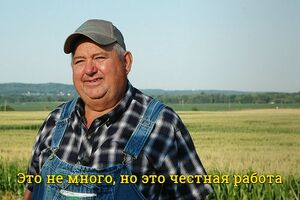

Результаты намекают на необходимость дальнейших исследований. Я понимаю, что высокий accuracy в некоторых местах, лишь говорит о том, что модель хорошо умеет предсказывать нули... Для предсказания секций, очевидно, нужен более глубокий анализ. Однако, если посмотреть на результаты схожих моделей на англоязычном датасете Wiki-727k, которые были представлены в статье [Text Segmentation by Cross Segment Attention](https://aclanthology.org/2020.emnlp-main.380.pdf), то можно увидеть, что лучшая модель там показала `f1_score = 66.5`. Возможно, всё не так уж и печально.

**1). Почему Hierarchical BERT хуже BiLSTM?**
- Начать можно со сложности для трансформера это (seq_len^2 * hidden_size), а для LSTM (seq_len * hidden_size^2). Для супер длинных документов, где seq_len будет больше, чем hidden, LSTM будет показывать себя а) быстрее, б) не будет терять контекста, в то время как у траснформера он будет ограничиваться фиксированной длиной. Также в процессе обучения своих моделей, одна из которых была похожа на Hier.Bert, а другая состояла из Bert + BiLSTM я заметил, что параметры первой весили ~340 Mb, в том время как у рекурентной лишь ~27 Mb.

**2). Насколько по размеру отличается lenta от tjournal?**
- Я честно пытался найти различия в статьях, но единственные отличительные черты tjournal'a, которые я заметил, так это упоминание самого TJ в их статьях и фразы 'Статья создана участником Лиги авторов' в конце документов.

**3). Как делался файнтьюнинг бертов?**
- В моих экспериментах fine-tuning проводился над второй частью модели, а именно 'bert-base-uncased'. Я делал его двумя этапами. Первым - замораживал веса самого берта, оставляя тренировать только веса "головы"-классификатора.
Вторым -  размораживал веса берта и обучал уже их вместе.

**4). Как считаются последовательные предложения**?
- Я не использовал в своих экспериментах модель Cross-segment Bert. Для того чтобы хоть как-то сохранить последовательность предложений, я не мешал данные при разбиениях.

**Что я бы сделал дальше?**
- Поиск и тестирование иных энкодеров предложений и их сравнение среди различных сэмплов, к примеру по косинусному расстоянию. 
- Исследование методов борьбы с сильным дисбалансом классов ~~*когда только приступил к задаче натыкался на статью с описанными методами, но потерял ее :(*~~
- Анализ выхода классификаторов, стоит декодировать и посмотреть на  предложения и их предсказанные метки, возможно, как было сказано, метрика не до конца отображает качество разметки.
- Ну и из разряда совсем безумных, попробовать кластеризовать каждую статью и внутри кластера уже искать первое предложение абазаца и секции.